In [88]:
import os
import numpy as np
import struct
from numpy import zeros
import array
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import misc
import time
%matplotlib inline

In [89]:
def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = zeros((N, rows, cols), dtype='uint8')
    labels = zeros((N, 1), dtype='int8')
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = [label[0] for label in labels]
    return images, labels

In [90]:
tr,label = load_mnist("training")
tr_label = np.array(label,dtype = np.long)
tr_data = tr[0:50000]
va_data = tr[50000:60000]
train_label = tr_label[0:50000]
validate_label = tr_label[50000:60000]
te,te_label = load_mnist("testing")
te_label = np.array(te_label,dtype = np.long)

In [134]:
print(te_label.shape)

(10000,)


In [91]:
#scipy.misc.imread(d_tr)
def resize_data(dataset,size):
    rd = np.zeros((len(dataset),size,size))
    for img in range(len(dataset)):
        rd[img] = scipy.misc.imresize(dataset[img],(size,size))
    return rd

In [92]:
#resize the data set to 14*14
train = resize_data(tr_data,14)
test = resize_data(te,14)
validate = resize_data(tr_data,14)

In [93]:
# import needed library for MLP 
import torch
import torch.nn as nn
import torch.nn.functional
import torch.utils.data
from torch.autograd import Variable

In [94]:
# generalize
train = train/256
test = test/256
validate = validate/256

In [95]:
# import dataset yo torch dataloader
train_data =torch.utils.data.DataLoader(torch.from_numpy(train),batch_size = 100)
test_data =torch.utils.data.DataLoader(torch.from_numpy(test),batch_size = 100)
validate_data = torch.utils.data.DataLoader(torch.from_numpy(validate),batch_size = 100)
t_label =torch.from_numpy(train_label)
e_label = torch.from_numpy(te_label)
v_label = torch.from_numpy(validate_label)

In [111]:
#build MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.L1 = nn.Linear(196,700)
        self.drop1 = nn.Dropout(0.3)
        self.L2 = nn.Linear(700,300)
        self.drop2 = nn.Dropout(0.3)
        self.L3 = nn.Linear(300,10)

    def forward(self,din):
        din = din.view(-1,196)
        dout = torch.nn.functional.relu(self.drop1(self.L1(din)))
        dout = torch.nn.functional.relu(self.drop2(self.L2(dout)))
        return torch.nn.functional.softmax(self.L3(dout))
#calculate accuracy
def accuracy(preb,label):
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(preb,1)==label)
    test_np = np.float32(test_np)
    return (100*np.mean(test_np))    

In [112]:
def varification(ver_data,ver_label,var_model):
    var_sums=[]
    for n,var in enumerate(ver_data):
        var = var.type(torch.FloatTensor)
        var_label = ver_label[n*100:n*100+100].type(torch.LongTensor)
        var_input = torch.autograd.Variable(var).cuda()
        var_label = torch.autograd.Variable(var_label).cuda()
        var_output = var_model(var_input)
        var_sums.append(accuracy(var_output,var_label))
    return(sum(var_sums)/len(var_sums))

In [136]:
model = MLP().cuda()
sgd = torch.optim.SGD(model.parameters(),lr = 0.1,momentum = 0)
lossfunc = torch.nn.CrossEntropyLoss()
trace = []
trace_loss=[]
trace_acc = np.zeros((20,1))
for n in range(20):
    sums = []
    sum_loss=[]
    for i,data in enumerate(train_data):
        sgd.zero_grad()
        data = data.type(torch.FloatTensor)
        labels = t_label[i*100:i*100+100].type(torch.LongTensor)
        inputs = torch.autograd.Variable(data).cuda()
        labels = torch.autograd.Variable(labels).cuda()
        outputs = model(inputs)
        loss = lossfunc(outputs,labels)
        sum_loss.append(loss.cpu().data.numpy())
        sums.append(accuracy(outputs,labels))
        loss.backward()
        sgd.step()
    model1 = model
    trace_acc[n] = varification(test_data,e_label,model1)
    trace_loss.append(sum(sum_loss)/len(sum_loss))
    trace.append(sum(sums)/len(sums))

In [137]:
print(trace[19])

93.1640002012


In [126]:
#calculate accuracy
def vector(preb):
    preb = preb.cpu().data.numpy()
    test_np = np.argmax(preb,1)
    return test_np

In [131]:
sums = []
pred = np.zeros((10000,1))
for i,data in enumerate(test_data):
    data = data.type(torch.FloatTensor)
    labels = e_label[i*100:i*100+100].type(torch.LongTensor)
    inputs = torch.autograd.Variable(data).cuda()
    labels = torch.autograd.Variable(labels).cuda()
    outputs = model(inputs)
    sums.append(accuracy(outputs,labels))
    vect=vector(outputs)
    for n in range(100):
        pred[i*100+n]=vect[n]

In [124]:
from sklearn.metrics import confusion_matrix

In [135]:
confusion_matrix(pred,te_label,labels=None,sample_weight=None)

array([[ 973,    1,    3,    0,    0,    2,    2,    0,    3,    3],
       [   0, 1128,    0,    0,    0,    0,    3,    3,    0,    2],
       [   1,    0, 1020,    3,    5,    0,    0,    9,    4,    0],
       [   0,    0,    2,  994,    0,    7,    1,    0,    7,    4],
       [   0,    0,    2,    0,  964,    1,    7,    1,    1,    9],
       [   0,    2,    0,    6,    0,  873,    3,    0,    3,    4],
       [   5,    1,    1,    0,    1,    2,  941,    0,    0,    1],
       [   1,    1,    2,    4,    3,    1,    0, 1008,    2,    2],
       [   0,    2,    2,    2,    1,    4,    1,    2,  952,    4],
       [   0,    0,    0,    1,    8,    2,    0,    5,    2,  980]], dtype=int64)

In [27]:
l = [1,2,3,4]
d=[]
d.append(l)

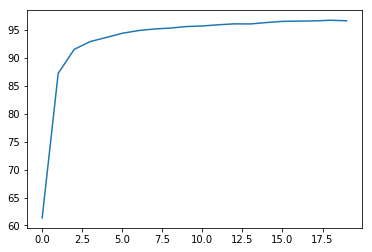

In [167]:
plt.plot(trace)

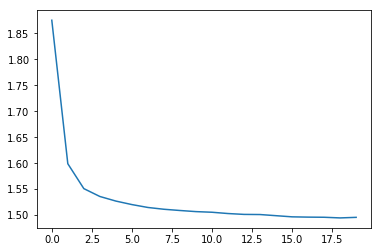

In [169]:
plt.plot(trace_loss)